# Precipitations during the Vaia event on Rotiano catchment

by the GEOframe group under the CC4 license

It needs **numpy** and **rasterio** installed. Then issue these commands in the console:
* item conda install numpy 
* item conda install rasterio

Also it needs [pycpt](https://github.com/agmunozs/PyCPT)

* pip install https://github.com/j08lue/pycpt/archive/master.zip
It contains various colormap in cpt format

Data are assumed to be in the data directory which is a folder under the level in which there is the present Notebook.

**This is still work in progress though** 

# Preliminary actions

In [1]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
#Playing with colormaps 
try:
    import pycpt
    topocmap = pycpt.load.cmap_from_cptcity_url('wkp/schwarzwald/wiki-schwarzwald-cont.cpt')
except:
    topocmap = 'Spectral_r'

In [2]:
#Modified From Bruno Ruas de Pihno http://geologyandpython.com/dem-processing.html
def coloured_distplot(elev, vmin,vmax,topocmap, label):
    elevlist = elev[~np.isnan(elev)]
    ay = sns.distplot(elevlist.ravel(), axlabel=label)
    ay = plt.gca()
    _ = [patch.set_color(topocmap(plt.Normalize(vmin=vmin, vmax=vmax)(patch.xy[0]))) for patch in ay.patches]
    _ = [patch.set_alpha(1) for patch in ay.patches]
    return ay
#ay.get_figure()#.savefig('images/1.png')

This hillshade function is dervied from http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

In [3]:
def hillshade(array, azimuth, angle_altitude):

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.


    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

# Importing data

In [4]:
os.getcwd()

'/Users/riccardo/Dropbox/A-Workspace/0-PrecipitationsVaia'

In [5]:
os.listdir('data')

['mask.prj',
 '.DS_Store',
 'tn_multiquad_200m',
 'multiquad_cropped_4m',
 'DEM_cut.asc',
 'Dem.prj',
 'Precipitazioni',
 'mask.shp',
 'mask.shx',
 'multiquad_cropped',
 'tn_kriging_anis_200m_cropped_4m',
 'Dem.asc',
 'tn_kriging_anis_200m_cropped',
 'mask.dbf',
 'tn_kriging_anis_200m',
 'multiquad_cropped_debris1']

In [6]:
os.chdir('data/multiquad_cropped_debris1')

In [7]:
fls=os.listdir()
fls[:5]

['tn20181027120000.asc',
 'tn20181030220000.sld',
 'tn20181027020000.asc',
 'tn20181030060000.asc',
 'tn20181030160000.asc']

In [8]:
sfls=sorted(fls)
sfls[:5]

['tn20181027010000.asc',
 'tn20181027010000.prj',
 'tn20181027010000.sld',
 'tn20181027020000.asc',
 'tn20181027020000.prj']

In [9]:
import glob

In [10]:
sfls=sorted(glob.glob("*.asc"))
sfls[:5]

['tn20181027010000.asc',
 'tn20181027020000.asc',
 'tn20181027030000.asc',
 'tn20181027040000.asc',
 'tn20181027050000.asc']

In [11]:
from datetime import datetime

In [12]:
dates=[]
for date in sfls:
    dates.append(datetime.strptime(date.split('tn')[1].split(".")[0],'%Y%m%d%H%M%S'))
    
dates[:5]

[datetime.datetime(2018, 10, 27, 1, 0),
 datetime.datetime(2018, 10, 27, 2, 0),
 datetime.datetime(2018, 10, 27, 3, 0),
 datetime.datetime(2018, 10, 27, 4, 0),
 datetime.datetime(2018, 10, 27, 5, 0)]

## Data Import with Rasterio

Information is verbatim copied from the [rasterio manual](https://automating-gis-processes.github.io/CSC18/lessons/L6/reading-raster.html)

Open the files 

In [13]:
dem=[]
for dt in sfls:
    dem.append(rasterio.open(dt))

In [14]:
dem[0]

<open DatasetReader name='tn20181027010000.asc' mode='r'>

Check the typeof data

In [15]:
type(dem[0])

rasterio.io.DatasetReader

Check the projection information

In [16]:
dem[0].crs

CRS.from_dict(init='epsg:25832')

Affine transform (how raster is scaled, rotated, skewed, and/or translated)

In [17]:
dem[0].transform

Affine(4.0, 0.0, 641791.0,
       0.0, -4.0, 5128682.0)

In [18]:
cellsize=dem[0].transform[0]
cellsize

4.0

DEM width

In [19]:
dem[0].width

258

DEM height

In [20]:
dem[0].height

258

In [21]:
dem[1].height

258

Number of bands

In [22]:
dem[0].count

1

Bounds of the file

In [23]:
dem[0].bounds

BoundingBox(left=641791.0, bottom=5127650.0, right=642823.0, top=5128682.0)

Driver (data format)

No data values for all channels

In [24]:
dem[0].nodatavals

(-9999.0,)

DEM metadata summary

In [25]:
dem[0].meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 258,
 'height': 258,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:25832'),
 'transform': Affine(4.0, 0.0, 641791.0,
        0.0, -4.0, 5128682.0)}

## Plots

In [26]:
ln=len(dem);
ln

96

### Setting novalues to nan

In [27]:
# elevation
i=0
elev=[]
for item in dem:
    elev.append(dem[i].read(1))
    # compute minimum value
    #amin=min(elev[i][elev[i] > 0])
    # set to "NAN" all negative values
    elev[i][elev[i] < 0]='NAN'
    i+=1
    

### Plotting with a decent color map

About colormaps in matplotlib https://matplotlib.org/tutorials/colors/colormaps.html

In [28]:
dates[0].strftime('%d/%m/%Y/%H/%M')

'27/10/2018/01/00'

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/Applications/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


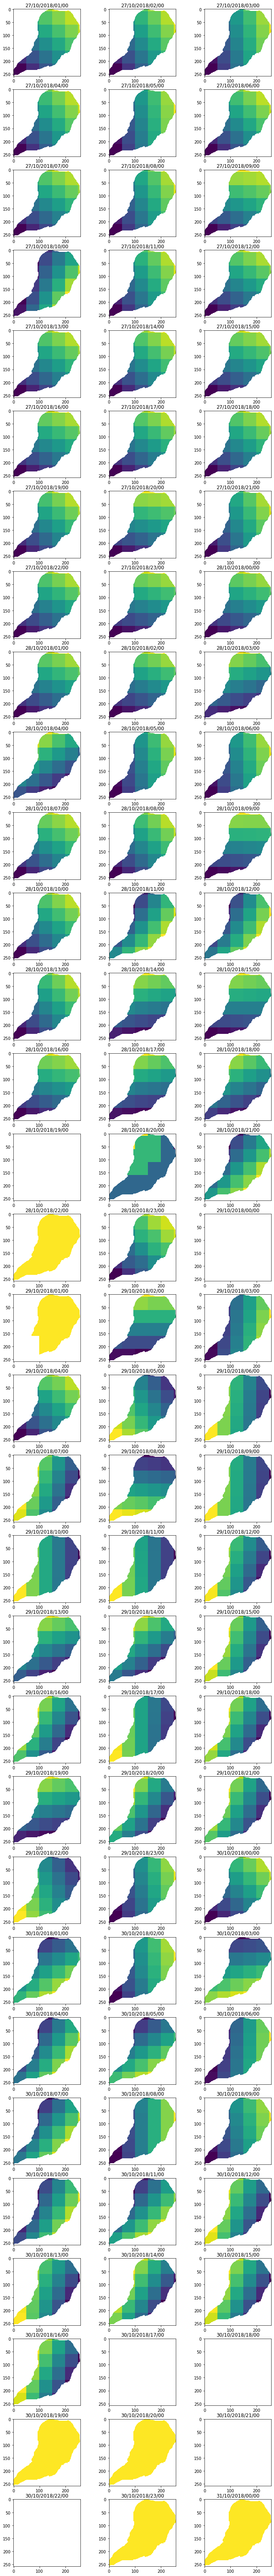

In [29]:
i=0
#fig=plt.figure()
fig=plt.figure(figsize=(12,120))
#fig.subplots_adjust(hspace=0.1, wspace=0.1)
m=1
for item in elev:
    #fig,ax = plt.subplots(figsize=(10,6))     #get the current axes 
    ax=fig.add_subplot(33,3,m)
    ax.set_aspect(1);
    ax.imshow(elev[m-1],cmap="viridis_r")
    ax.set_title(dates[m-1].strftime('%d/%m/%Y/%H/%M')) 
    m+=1

In [33]:
elev[0][~np.isnan(elev[0])].sum()

76386.945

In [34]:
elev[0][~np.isnan(elev[0])].mean()

2.308809

In [35]:
elev[0][~np.isnan(elev[0])].max()

2.674

In [36]:
total_precipitation=[]
mean_precipitation=[]
max_precipitation=[]
areal_extent=[]
m=0
for item in elev:
    elevlist = elev[m][~np.isnan(elev[m])]
    elevlist=elevlist.ravel()
    if len(elevlist!=0):
        lenlist= len(elevlist)
        sumlist = elevlist.sum()*cellsize*cellsize*0.001
        meanlist = elevlist.mean()
        maxlist = elevlist.max()
        
    else:
        lenlist =0
        sumlist =0 
        meanlist=0
        maxlist=0
    areal_extent.append(lenlist*cellsize*cellsize/10**6)
    total_precipitation.append(sumlist)
    mean_precipitation.append(meanlist)
    max_precipitation.append(maxlist)
    m+=1
cumulative_precipitation=np.cumsum(total_precipitation)
cumulative_mean_precipitation=np.cumsum(mean_precipitation)

In [37]:
len(areal_extent)

96

In [38]:
max_area=max(areal_extent)
max_area

0.52936

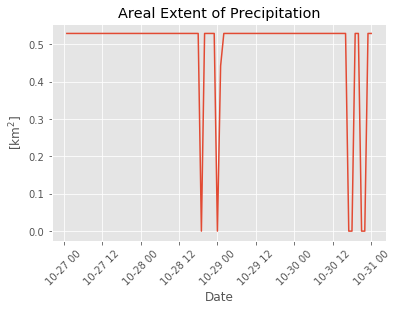

In [40]:
plt.style.use('ggplot')
fg=plt.figure()
ax=fg.add_subplot(111)
ax.plot(dates,areal_extent)
#ax.set_aspect(aspect=0.2)
ax.set_ylabel("[km$^2$]")
ax.set_xlabel("Date")
ax.set_title("Areal Extent of Precipitation")
plt.xticks(rotation=45)
plt.show()

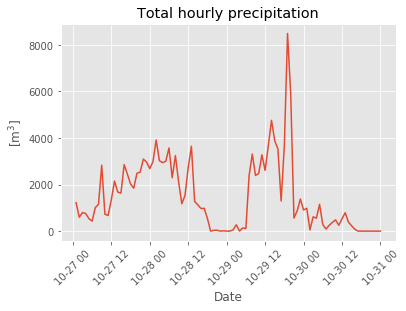

In [41]:
#plt.style.use('ggplot')
fg1=plt.figure()
ax1=fg1.add_subplot(111)
ax1.plot(dates,total_precipitation)
#ax1.set_aspect(aspect=1)
ax1.set_ylabel("[m$^3$]")
ax1.set_xlabel("Date")
ax1.set_title("Total hourly precipitation")
plt.xticks(rotation=45)
plt.show()

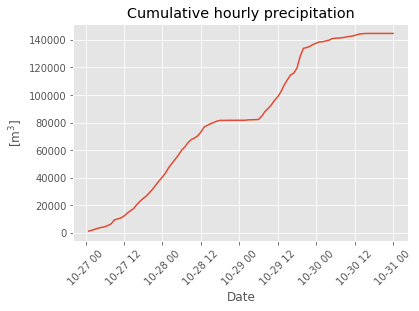

In [42]:
fg2=plt.figure()
ax2=fg2.add_subplot(111)
ax2.plot(dates,cumulative_precipitation)
#ax2.set_aspect(aspect=1)
ax2.set_ylabel("[m$^3$]")
ax2.set_xlabel("Date")
ax2.set_title("Cumulative hourly precipitation")
plt.xticks(rotation=45)
plt.show()

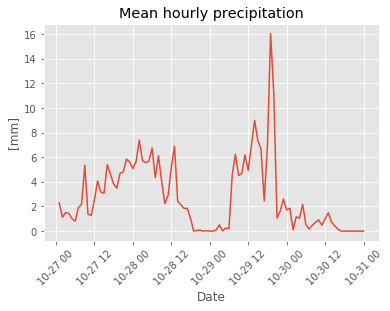

In [43]:
fg3=plt.figure()
ax3=fg3.add_subplot(111)
ax3.plot(dates,mean_precipitation)
#ax3.set_aspect(aspect=1)
ax3.set_ylabel("[mm]")
ax3.set_xlabel("Date")
ax3.set_title("Mean hourly precipitation")
plt.xticks(rotation=45)
plt.show()

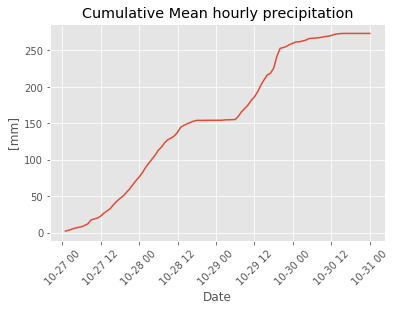

In [44]:
fg4=plt.figure()
ax4=fg4.add_subplot(111)
ax4.plot(dates,cumulative_mean_precipitation)
#ax4.set_aspect(aspect=1)
ax4.set_ylabel("[mm]")
ax4.set_xlabel("Date")
ax4.set_title("Cumulative Mean hourly precipitation")
plt.xticks(rotation=45)
plt.show()

In [45]:
meanPrecipitationRotiano=pd.DataFrame(mean_precipitation,index=dates,columns=["Precipitation [mm]"])

In [46]:
meanPrecipitationRotiano[:5]

,Precipitation [mm]
2018-10-27 01:00:00,2.308809
2018-10-27 02:00:00,1.127824
2018-10-27 03:00:00,1.506542
2018-10-27 04:00:00,1.425363
2018-10-27 05:00:00,1.014232


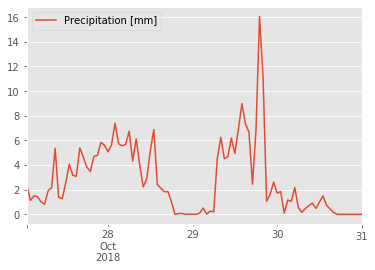

In [47]:
meanPrecipitationRotiano.plot()

In [62]:
meanPrecipitationRotiano.to_csv("MeanPrecipitationRotiano")

In [63]:
os.listdir()

['tn20181027120000.asc',
 'tn20181030220000.sld',
 'tn20181027020000.asc',
 'tn20181030060000.asc',
 'tn20181030160000.asc',
 'tn20181028050000.asc',
 'tn20181028150000.asc',
 'tn20181028210000.sld',
 'tn20181029200000.asc',
 'tn20181029140000.sld',
 'tn20181029040000.sld',
 'tn20181029080000.prj',
 'tn20181029180000.prj',
 'tn20181027050000.prj',
 'tn20181027150000.prj',
 'tn20181027190000.sld',
 'tn20181027090000.sld',
 'tn20181030110000.prj',
 'tn20181030010000.prj',
 'tn20181028120000.prj',
 'tn20181028020000.prj',
 'tn20181027230000.prj',
 'tn20181029220000.sld',
 'tn20181029060000.asc',
 'tn20181029160000.asc',
 'tn20181028170000.sld',
 'tn20181028070000.sld',
 'tn20181028230000.asc',
 'tn20181029110000.prj',
 'tn20181029010000.prj',
 'tn20181030200000.asc',
 'tn20181027100000.sld',
 'tn20181030140000.sld',
 'tn20181030040000.sld',
 'tn20181030080000.prj',
 'tn20181030180000.prj',
 'tn20181029230000.sld',
 'tn20181029170000.asc',
 'tn20181029070000.asc',
 'tn20181027220000.prj',
